In [63]:
# Get the data
! git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [64]:
# List data
!ls track

driving_log.csv  IMG


In [65]:
!pip3 install imgaug

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping 
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import ntpath
import cv2
import random
import pandas as pd
import os
from sklearn.utils import shuffle
import matplotlib.image as mpimg

In [67]:
# Set data directory
datadir = 'track'

# Set columns
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
# Read in csv
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)

# Output all info
pd.set_option('display.max_colwidth', -1)

# Output top 5 rows
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # Remove the CWD from sys.path while we load stuff.


center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

In [68]:
# Create function to get the tail of the path
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

# Convert center, left, and right to only return tail of path
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

# Output data
data.head()

center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

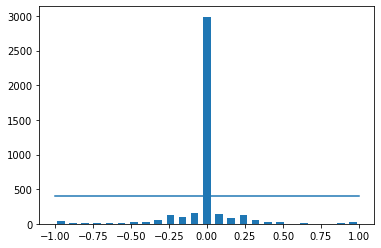

In [69]:
# Plot steering angle for every image in a histogram

# Set number of bins
num_bins = 25

# Set a maximum number of samples per bin
max_samples_per_bin = 400

# Get the histogram values for steering angle into 25 bins
hist, bins = np.histogram(data['steering'], bins=num_bins)

# Center the values around 0
center = (bins[:-1] + bins[1:]) * 0.5

# Plot histogram
plt.bar(center, hist, width=0.05)
# Plot threshold line
plt.plot((np.min(data['steering']), np.max(data['steering'])), (max_samples_per_bin, max_samples_per_bin))

Removed: 2590
Remaining: 1463


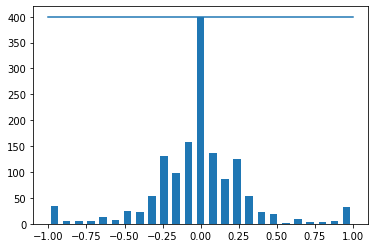

In [70]:
# Make our distribution more uniform
remove_list = []

# Loop through all bins
for j in range(num_bins):
  list_ = []
  # For each steering angle
  for i in range(len(data['steering'])):
    # If the steering angle for this observation is greater than the bin value but less then the next bin value
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      # Append index of steering angle to list.
      list_.append(i)
  # We then shuffle the list,
  list_ = shuffle(list_)
  # Then remove enough elements so that there is 200 or less elements
  list_ = list_[max_samples_per_bin:]
  # Add indexes of items to remove to list
  remove_list.extend(list_)

print(f'Removed: {len(remove_list)}')
# Drop entries from data
data = data.drop(data.index[remove_list])

print(f'Remaining: {len(data)}')

hist, _ = np.histogram(data['steering'], num_bins)

# Plot new histogram
plt.bar(center, hist, width=0.05)
# Plot threshold line
plt.plot((np.min(data['steering']), np.max(data['steering'])), (max_samples_per_bin, max_samples_per_bin))


In [71]:
def load_img_steering(datadir, df):
  # Initialized lists
  image_path = []
  steering = []
  # For each row in the dataframe
  for i in range(len(df)):
    # Get the row according to index
    indexed_data = df.iloc[i]
    # Get the center, left, and right columns for that row
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    # Append the path for the images by joining directory and center column stripped of spaces if it had any
    image_path.append(os.path.join(datadir, center.strip()))
    # Append the steering angle as a float
    steering.append(float(indexed_data[3]))

  # Convert to numpy arrays
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)

  return image_paths, steerings

# Get array of images (training) and array of steering angles (label)
image_paths, steerings = load_img_steering(datadir=datadir + '/IMG', df=data)

In [72]:
# Split the data into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print(f'Training Samples: {len(X_train)} \n Valid Samples {len(X_valid)}')

Training Samples: 1170 
 Valid Samples 293


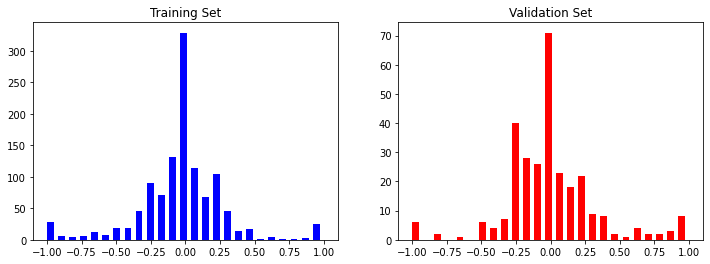

In [73]:
# Plot the distribution of the Training and Validation Labels
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training Set')

axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation Set');

In [74]:
# Apply zoom to image
def zoom(image):
  # Zoom up to 305 of image
  zoom = iaa.Affine(scale=(1, 1.3))
  # Apply zoom
  image = zoom.augment_image(image)
  return image



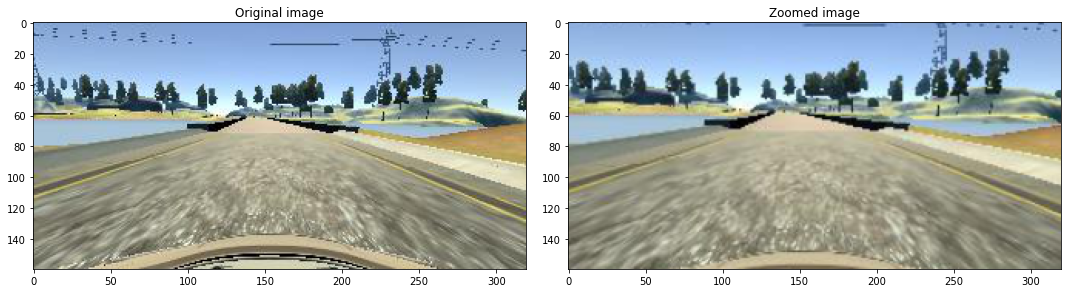

In [75]:
# Get random image
image = image_paths[random.randint(0, 1000)]
# Read in random image
original_image = mpimg.imread(image)
# Apply zoom to image
zoomed_image = zoom(original_image)

# Set up grid with one row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

# Show original image
axes[0].imshow(original_image)
axes[0].set_title('Original image')

# Show zoomed image
axes[1].imshow(zoomed_image)
axes[1].set_title('Zoomed image');

In [76]:
# Translates image to the left or right by some value less than or equal to 10%
def pan(image):
  # Affine - deals with transfomrations that preserve straight lines in object
  pan = iaa.Affine(translate_percent={'x':(-0.1, 0.1), 'y': (-0.1, 0.1)})
  # Apply pan parameters
  image = pan.augment_image(image)
  return image

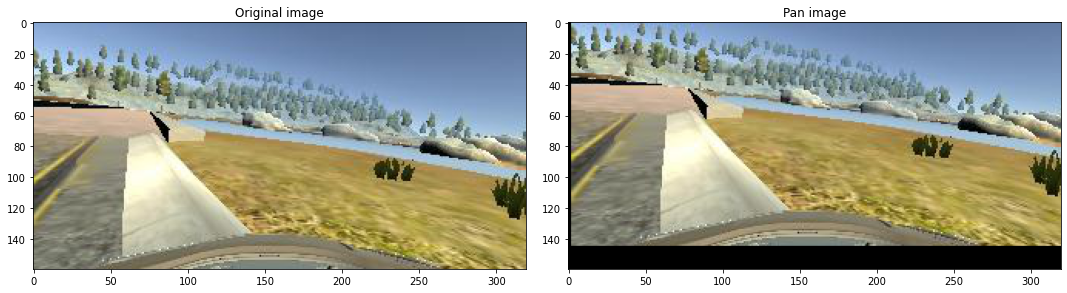

In [77]:
# Get random image
image = image_paths[random.randint(0, 1000)]
# Read in random image
original_image = mpimg.imread(image)
# Apply zoom to image
pan_image = pan(original_image)

# Set up grid with one row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

# Show original image
axes[0].imshow(original_image)
axes[0].set_title('Original image')

# Show zoomed image
axes[1].imshow(pan_image)
axes[1].set_title('Pan image');

In [78]:
def img_random_brightness(image):
  # Multiplies all pixel intensities inside the image. Darker if value is less than 1; Bright if > 1
  brightness = iaa.Multiply(mul=(0.2, 1.2))
  # Apply brightness augmentation
  image = brightness.augment_image(image)
  return image

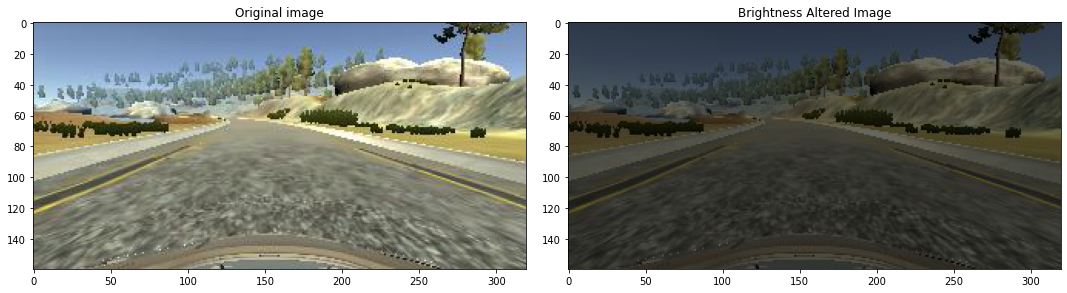

In [79]:
# Get random image
image = image_paths[random.randint(0, 1000)]
# Read in random image
original_image = mpimg.imread(image)
# Apply zoom to image
brightness_altered_image = img_random_brightness(original_image)

# Set up grid with one row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

# Show original image
axes[0].imshow(original_image)
axes[0].set_title('Original image')

# Show zoomed image
axes[1].imshow(brightness_altered_image)
axes[1].set_title('Brightness Altered Image');

In [80]:
# Flip images: Randomly flips images to balance our dataset
def img_random_flip(image, steering_angle):
  # Flip image: 0 = vertical flip, 1 = horizontal flip, -1 = combination of both
  image = cv2.flip(image, 1)
  # If image is flipped then we need to flip steering angle by taking negative
  steering_angle = -steering_angle

  return image, steering_angle

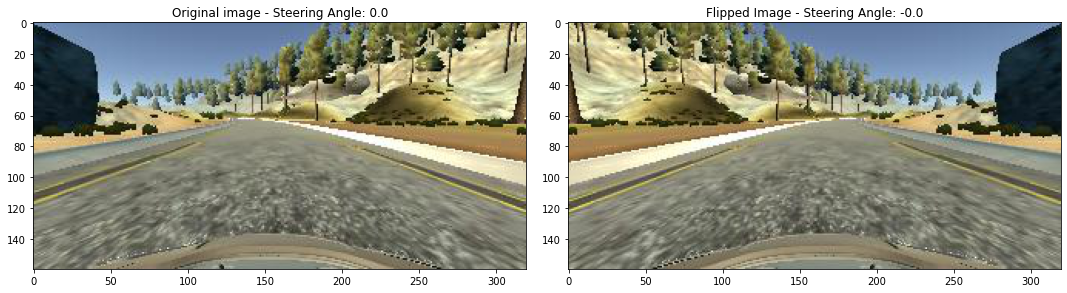

In [81]:
# Set random index
random_index = random.randint(0, 1000)
# Get random image
image = image_paths[random_index]
# Get steering angle
steering_angle = steerings[random_index]

# Read in random image
original_image = mpimg.imread(image)
# Apply zoom to image
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

# Set up grid with one row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

# Show original image
axes[0].imshow(original_image)
axes[0].set_title(f'Original image - Steering Angle: {str(steering_angle)}')

# Show zoomed image
axes[1].imshow(flipped_image)
axes[1].set_title(f'Flipped Image - Steering Angle: {str(flipped_steering_angle)}');

In [82]:
def random_augment(image, steering_angle):
  # Read in image from image path
  image = mpimg.imread(image)

  # Apply pan augmentation on 50% of images
  if np.random.rand() < 0.5:
    image = pan(image)
  # Apply zoom augmentation on 50% of images
  if np.random.rand() < 0.5:
    image = zoom(image)
  # Apply brightness augmentation on 50% of images
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  # Apply flip augmentation on 50% of images
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, float(steering_angle))

  return image, steering_angle


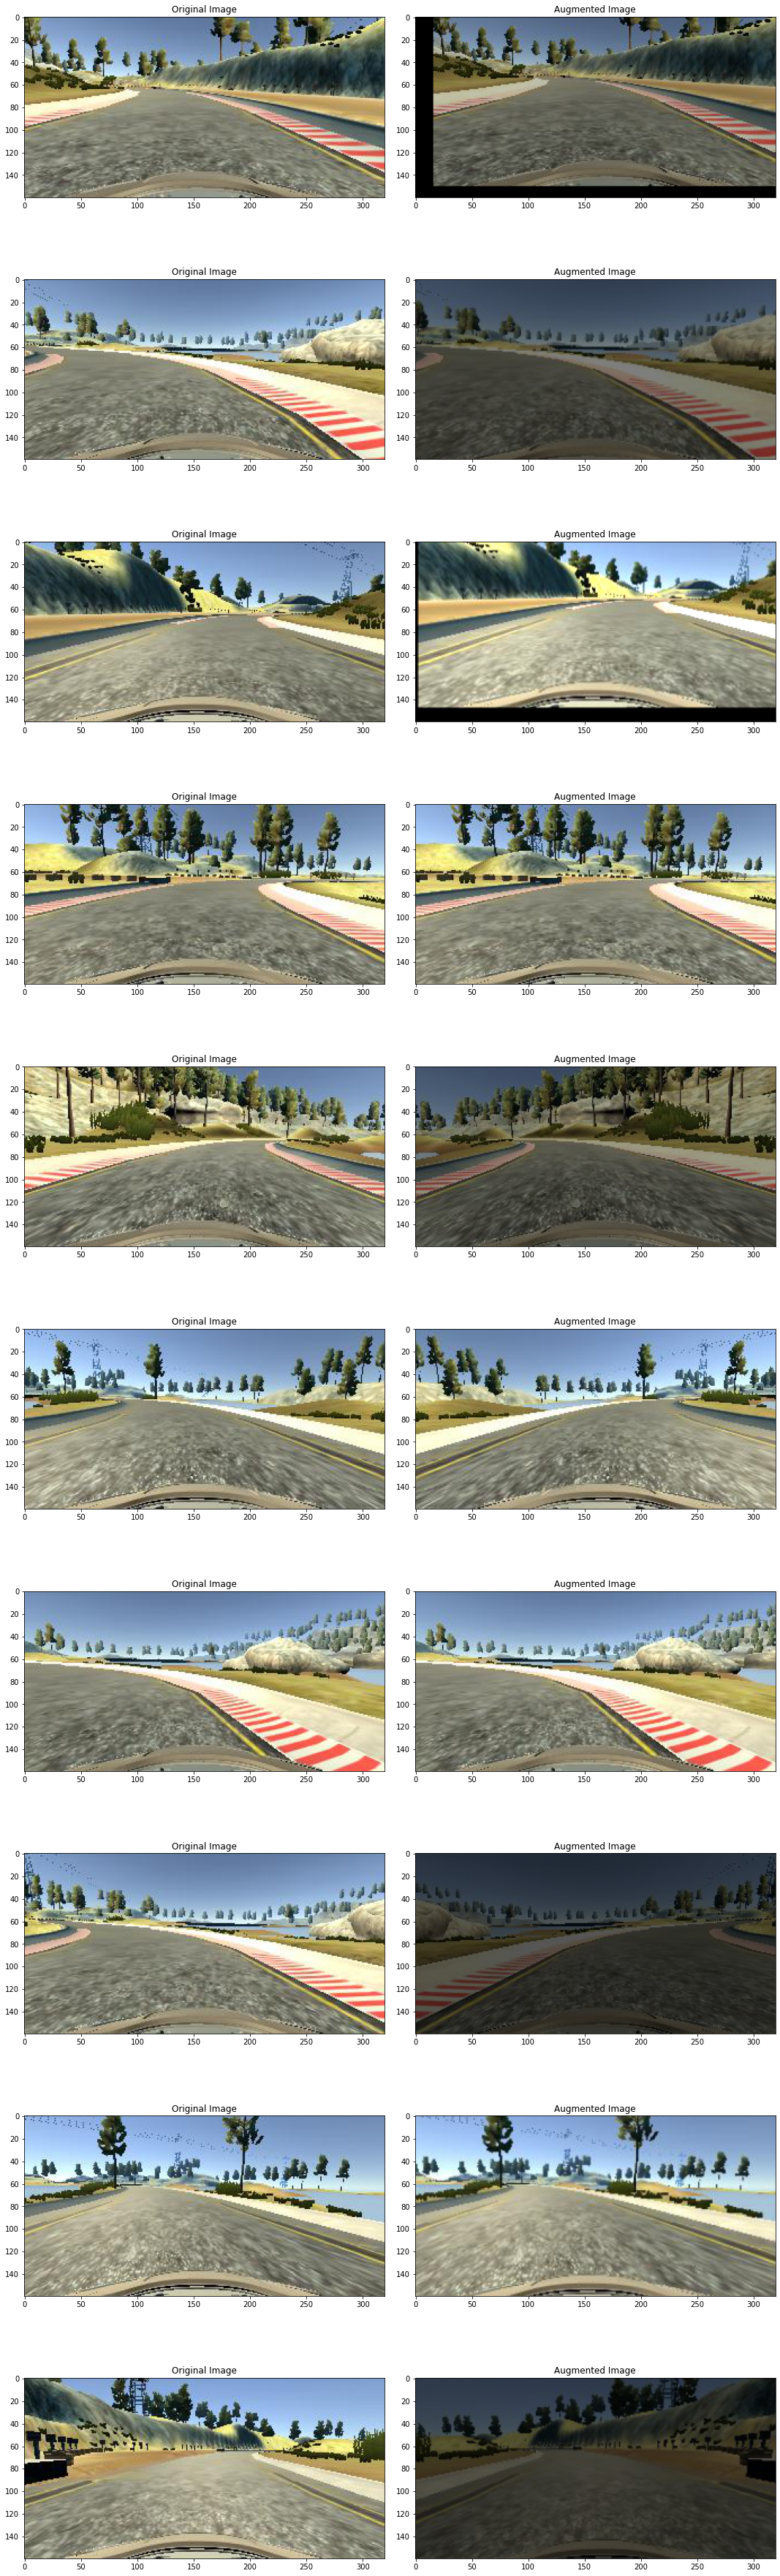

In [83]:
# Set number of columns and rows in plot
ncol = 2
nrow = 10

# Set up the figure
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

# For 10 random images
for i in range(10):
  # Get a random index
  randnum = random.randint(0, len(image_paths) - 1)

  # Get the random image and steering angle for that image
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  # Read in the random image
  original_image = mpimg.imread(random_image)
  # Augment the image
  augmented_image, steering = random_augment(random_image, random_steering)

  # Plot the original image
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")

  # Plot the augmented image
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

In [84]:
# Preprocess our images
def img_preprocess(img):
  # Crop image to remove areas the hood of car and background which are not relevant
  # Image has height of 160 and width of 320; Only keep relevant area
  img = img[60:135,:,:]

  # Convert color space to YUV (y = luminosity, uv = chrominance components) to fit nvidia model architecture format
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

  # Apply Gaussian blur to smooth image and reduce noise
  img = cv2.GaussianBlur(img,  (3, 3), 0)

  # Reduce size of image to fit nvidia model architecture
  img = cv2.resize(img, (200, 66))

  # Normalize image
  img = img/255
  return img


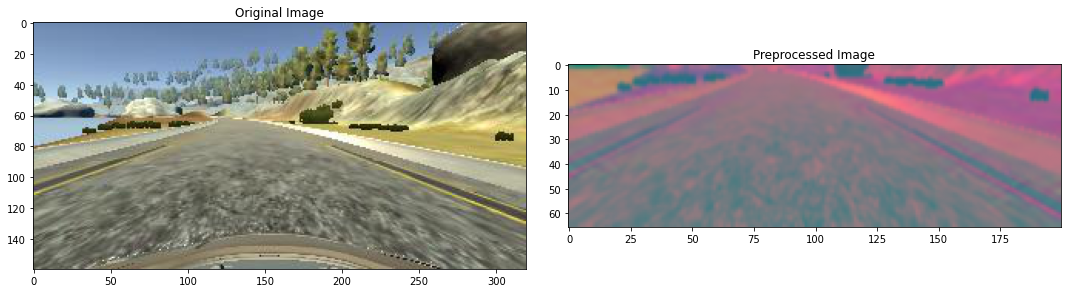

In [85]:
# Get image path
image = image_paths[100]

# Read in image
original_image = mpimg.imread(image)
# Apply preprocessing to image
preprocessed_image = img_preprocess(original_image)

# Set up a grid with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()

# Plot the original image
axes[0].imshow(original_image)
axes[0].set_title('Original Image')

# Plot the preprocessed image
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image');

In [86]:
def batch_generator(image_paths, steering_angle, batch_size, istraining):
  # Continuous infinitely
  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      # Get random index
      random_index = random.randint(0, len(image_paths) - 1)

      # If it is a training image
      if istraining:
        img, steering = random_augment(image_paths[random_index], steering_angle[random_index])
      # If it is a validation image
      else:
        # Read in image
        img = mpimg.imread(image_paths[random_index])
        # Get steering angle of image
        steering = steering_angle[random_index]

      # Preprocess the image
      img = img_preprocess(img)
      # Append image and steering angles
      batch_img.append(img)
      batch_steering.append(steering)

    # Yield batch images and steering angles as numpy arrays
    # yield = values do not reinitialize; takes on its old value
    yield (np.asarray(batch_img), np.asarray(batch_steering))

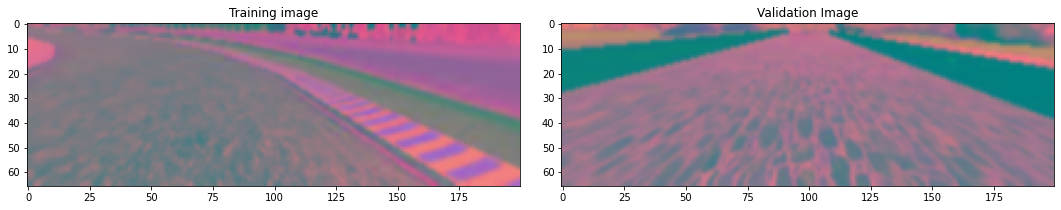

In [87]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, True))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, False))

# Set up grid with one row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

# Show original image
axes[0].imshow(x_train_gen[0])
axes[0].set_title('Training image')

# Show zoomed image
axes[1].imshow(x_valid_gen[0])
axes[1].set_title('Validation Image');

In [88]:
# Apply preprocessing to training data
#X_train = np.array(list(map(img_preprocess, X_train)))

# Apply preprocessing to validation data
#X_valid = np.array(list(map(img_preprocess, X_valid)))

In [89]:
# Verify we preprocessed correctly
#plt.imshow(X_train[random.randint(0, len(X_train)-1)])
#plt.axis('off')

#print(X_train.shape)

In [90]:
# Define nvidia model
def nvidia_model():
  # Initialize model
  model = Sequential()
  # Use elu activation function to avoid dead relu problem which occurs when too many negative numbers are passed to the relu function
  # which results in a gradient of 0, so the weights are never updated during backpropagation, so those nodes are eliminated
  # and the same value is passed through the model due to the lack of updating the weights

  # Add Convolutional Layer
  model.add(Conv2D(filters=24, kernel_size=5, strides=(2,2), activation='elu', input_shape=(66, 200, 3)))
  # Add Convolutional Layer
  model.add(Conv2D(filters=36, kernel_size=5, strides=(2,2), activation='elu'))
  # Add Convolutional Layer
  model.add(Conv2D(filters=48, kernel_size=5, strides=(2,2), activation='elu'))
  # Add Convolutional Layer
  model.add(Conv2D(filters=64, kernel_size=3, strides=(1,1), activation='elu'))
  # Add Convolutional Layer
  model.add(Conv2D(filters=64, kernel_size=3, strides=(1,1), activation='elu'))

  # Add a Dropout Layer which randomly sets the fraction of specified percentage (50%) of nodes to 0
  #model.add(Dropout(0.5))

  # Flatten into one dimensional array
  model.add(Flatten())

  # Add Fully Connected Layer
  model.add(Dense(100, activation='elu'))
  # Add a Dropout Layer which randomly sets the fraction of specified percentage (50%) of nodes to 0
  #model.add(Dropout(0.5))

  # Add Fully Connected Layer
  model.add(Dense(50, activation='elu'))
  # Add a Dropout Layer which randomly sets the fraction of specified percentage (50%) of nodes to 0
  #model.add(Dropout(0.5))

  # Add Fully Connected Layer
  model.add(Dense(10, activation='elu'))
  # Add a Dropout Layer which randomly sets the fraction of specified percentage (50%) of nodes to 0
  #model.add(Dropout(0.5))

  # Add Output Layer with one output node since it is a regression problem
  model.add(Dense(1))
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

  return model

In [91]:
model = nvidia_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)              

In [92]:
from tensorflow.keras.callbacks import EarlyStopping
# Implement Early Stopping
callbacks = EarlyStopping(monitor='val_loss', patience=2)

In [93]:
# Fit model to generator
history = model.fit(batch_generator(X_train, y_train, batch_size=100, istraining=True), steps_per_epoch=300,
                    epochs=10, validation_data=batch_generator(X_valid, y_valid, 100, False), validation_steps=200, verbose=1, shuffle=True)
#history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), batch_size=100, verbose=1, shuffle=1, callbacks=[callbacks])

Epoch 1/10
300/300 [==============================] - 225s 749ms/step - loss: 0.0763 - val_loss: 0.0616
Epoch 2/10
300/300 [==============================] - 227s 755ms/step - loss: 0.0617 - val_loss: 0.0501
Epoch 3/10
300/300 [==============================] - 226s 754ms/step - loss: 0.0575 - val_loss: 0.0488
Epoch 4/10
300/300 [==============================] - 227s 756ms/step - loss: 0.0560 - val_loss: 0.0413
Epoch 5/10
300/300 [==============================] - 226s 754ms/step - loss: 0.0515 - val_loss: 0.0377
Epoch 6/10
300/300 [==============================] - 228s 760ms/step - loss: 0.0453 - val_loss: 0.0351
Epoch 7/10
300/300 [==============================] - 227s 758ms/step - loss: 0.0416 - val_loss: 0.0389
Epoch 8/10
300/300 [==============================] - 226s 753ms/step - loss: 0.0408 - val_loss: 0.0371
Epoch 9/10
300/300 [==============================] - 226s 754ms/step - loss: 0.0382 - val_loss: 0.0409
Epoch 10/10
300/300 [==============================] - 225s 751m

Text(0.5, 0, 'Epoch')

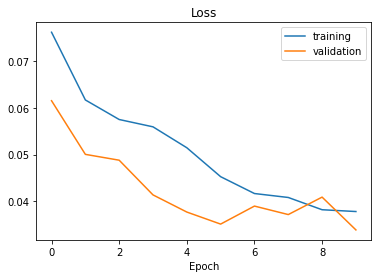

In [94]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])

plt.title('Loss')
plt.xlabel('Epoch')

In [95]:
# Save model
model.save('model.h5')

In [96]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>